In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

from collections import namedtuple

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
Options = namedtuple("Options", 'dataroot workers batchSize imageSize nz ngf ndf niter lr beta1 cuda ngpu netG netD outf manualSeed dataset')
AttackOptions = namedtuple("AttackOptions", 'dataroot workers batchSize imageSize nz ngf ndf niter lr beta1 cuda ngpu netBBG netWBG netBBD netWBD outf manualSeed dataset')

torch.set_default_dtype(torch.float32)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    def __init__(self, ngpu, nz, ngf, nc):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


class Discriminator(nn.Module):
    def __init__(self, ngpu, nc, ndf):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

In [3]:
def accuracy(netD, trainloader, testloader, trainset, device):
  predictions = []

  # loop over training data
  for i, data in enumerate(trainloader, 0):
      real_cpu = data[0].to(device)
      output = netD(real_cpu)
      output = [x for x in output.detach().cpu().numpy()]
      output = list(zip(output, ['train' for _ in range(len(output))]))
      predictions.extend(output)

  # loop over test data
  for i, data in enumerate(testloader, 0):
      real_cpu = data[0].to(device)
      output = netD(real_cpu)
      output = [x for x in output.detach().cpu().numpy()]
      output = list(zip(output, ['test' for _ in range(len(output))]))
      predictions.extend(output)

  predictions = [x[1] for x in sorted(predictions, reverse=True)[:len(trainset)]]
  accuracy = predictions.count('train')/float(len(trainset))
  return accuracy

def sample_dataset(dataset, p):
    original_dataset_size = len(dataset)
    subset_size = int(p * original_dataset_size)
    indices = torch.randperm(original_dataset_size)[:subset_size]
    
    return torch.utils.data.Subset(dataset, indices)

In [4]:
def train_gan(opt, trainset, testset):
  try:
    os.makedirs(opt.outf)
  except OSError:
      pass

  if opt.manualSeed is None:
      opt.manualSeed = random.randint(1, 10000)
  print("Random Seed: ", opt.manualSeed)
  random.seed(opt.manualSeed)
  torch.manual_seed(opt.manualSeed)

  cudnn.benchmark = True

  # Data
  print('==> Preparing data..')

  trainloader = torch.utils.data.DataLoader(trainset, batch_size=opt.batchSize, shuffle=True, num_workers=int(opt.workers))

  testloader = torch.utils.data.DataLoader(testset, batch_size=opt.batchSize, shuffle=True, num_workers=int(opt.workers))

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  ngpu = int(opt.ngpu)
  nz = int(opt.nz)
  ngf = int(opt.ngf)
  ndf = int(opt.ndf)
  nc = 3

  netG = Generator(ngpu, nz, ngf, nc).to(device)
  netG.apply(weights_init)
  if opt.netG != '':
      netG.load_state_dict(torch.load(opt.netG))
  print(netG)

  netD = Discriminator(ngpu, nc, ndf).to(device)
  netD.apply(weights_init)
  if opt.netD != '':
      netD.load_state_dict(torch.load(opt.netD))
  print(netD)

  criterion = nn.BCELoss()

  fixed_noise = torch.randn(opt.batchSize, nz, 1, 1, device=device)
  real_label = 1.0
  fake_label = 0.0

  # setup optimizer
  optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
  optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

  lossesD = []
  lossesG = []

  accuracies = []
  for epoch in range(opt.niter):
      mean_lossD = 0
      mean_lossG = 0

      netD.train()
      netG.train()
      for i, data in enumerate(trainloader, 0):
          ############################
          # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
          ###########################
          # train with real
          netD.zero_grad()
          real_cpu = data[0].to(device)
          batch_size = real_cpu.size(0)
          label = torch.full((batch_size,), real_label, device=device)

          output = netD(real_cpu)
          errD_real = criterion(output, label)
          errD_real.backward()
          D_x = output.mean().item()

          # train with fake
          noise = torch.randn(batch_size, nz, 1, 1, device=device)
          fake = netG(noise)
          label.fill_(fake_label)
          output = netD(fake.detach())
          errD_fake = criterion(output, label)
          errD_fake.backward()
          D_G_z1 = output.mean().item()
          errD = errD_real + errD_fake
          mean_lossD = mean_lossD + errD.item()
          optimizerD.step()

          ############################
          # (2) Update G network: maximize log(D(G(z)))
          ###########################
          netG.zero_grad()
          label.fill_(real_label)  # fake labels are real for generator cost
          output = netD(fake)
          errG = criterion(output, label)
          mean_lossG = mean_lossG + errG.item()
          errG.backward()
          D_G_z2 = output.mean().item()
          optimizerG.step()

          print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                % (epoch, opt.niter, i, len(trainloader),
                  errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
          if i % 100 == 0:
              vutils.save_image(real_cpu,
                      '%s/real_samples.png' % opt.outf,
                      normalize=True)
              fake = netG(fixed_noise)
              vutils.save_image(fake.detach(),
                      '%s/fake_samples_epoch_%03d.png' % (opt.outf, epoch),
                      normalize=True)
      netD.eval()
      netG.eval()

      mean_lossD = mean_lossD / float(len(trainloader))
      mean_lossG = mean_lossG / float(len(trainloader))

      lossesD.append(mean_lossD)
      lossesG.append(mean_lossG)

      accuracy_attack = accuracy(netD, trainloader, testloader, trainset, device)
      accuracies.append(accuracy_attack)
      print(f'Accuracy: {accuracy_attack}, Mean Loss D: {mean_lossD}, Mean Loss G: {mean_lossG}')

      # do checkpointing
      torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
      torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))

  plt.plot(lossesD)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss Discriminator')
  plt.show()

  plt.plot(lossesG)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss Generator')
  plt.show()

  plt.plot(accuracies)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Accuracy White Box')
  plt.show()
  
  return lossesD, lossesG, accuracies

In [5]:
def blackbox_attack(opt, trainset, testset):
  try:
      os.makedirs(opt.outf)
  except OSError:
      pass

  if opt.manualSeed is None:
      opt.manualSeed = random.randint(1, 10000)
  print("Random Seed: ", opt.manualSeed)
  random.seed(opt.manualSeed)
  torch.manual_seed(opt.manualSeed)

  cudnn.benchmark = True

  # Data
  print('==> Preparing data..')
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=opt.batchSize, shuffle=True, num_workers=int(opt.workers))

  testloader = torch.utils.data.DataLoader(testset, batch_size=opt.batchSize, shuffle=True, num_workers=int(opt.workers))

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  ngpu = int(opt.ngpu)
  nz = int(opt.nz)
  ngf = int(opt.ngf)
  ndf = int(opt.ndf)
  nc = 3

  netBBG = Generator(ngpu, nz, ngf, nc).to(device)
  netBBG.load_state_dict(torch.load(opt.netBBG))

  netBBD = Discriminator(ngpu, nc, ndf).to(device)
  netBBD.load_state_dict(torch.load(opt.netBBD))

  netWBG = Generator(ngpu, nz, ngf, nc).to(device)
  netWBG.apply(weights_init)
  if opt.netWBG != '':
      netWBG.load_state_dict(torch.load(opt.netWBG))

  netWBD = Discriminator(ngpu, nc, ndf).to(device)
  netWBD.apply(weights_init)
  if opt.netWBD != '':
      netWBD.load_state_dict(torch.load(opt.netWBD))

  netBBG.eval()
  netBBD.eval()

  ##### Black-box attack ####
  # Trains another GAN on the output of the black-box
  # Then launches whitebox attack with trained Discriminator


  criterion = nn.BCELoss()

  fixed_noise = torch.randn(opt.batchSize, nz, 1, 1, device=device)
  real_label = 1.0
  fake_label = 0.0

  # setup optimizer
  optimizerD = optim.Adam(netWBD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
  optimizerG = optim.Adam(netWBG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

  lossesD = []
  lossesG = []

  accuracies = []

  for step in range(opt.niter):
      ############################
      # (1) update d network: maximize log(d(x)) + log(1 - d(g(z)))
      ###########################

      netWBD.train()
      netWBG.train()

      # generate "real"
      real_noise = torch.randn(opt.batchSize, nz, 1, 1, device=device)
      real_cpu = netBBG(real_noise)

      # train with "real"
      netWBD.zero_grad()
      batch_size = real_cpu.size(0)
      label = torch.full((batch_size,), real_label, device=device)

      output = netWBD(real_cpu)
      errD_real = criterion(output, label)
      errD_real.backward()
      D_x = output.mean().item()

      # train with fake
      noise = torch.randn(batch_size, nz, 1, 1, device=device)
      fake = netWBG(noise)
      label.fill_(fake_label)
      output = netWBD(fake.detach())
      errD_fake = criterion(output, label)
      errD_fake.backward()
      D_G_z1 = output.mean().item()
      errD = errD_real + errD_fake
      optimizerD.step()

      ############################
      # (2) Update G network: maximize log(D(G(z)))
      ###########################
      netWBG.zero_grad()
      label.fill_(real_label)  # fake labels are real for generator cost
      output = netWBD(fake)
      errG = criterion(output, label)
      errG.backward()
      D_G_z2 = output.mean().item()
      optimizerG.step()
      
      

      print('[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
            % (step, opt.niter,
              errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
      if step % 500 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % opt.outf,
                    normalize=True)
            fake = netWBG(fixed_noise)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (opt.outf, step),
                    normalize=True)
            # do checkpointing
            torch.save(netWBG.state_dict(), '%s/netWBG_step_%d.pth' % (opt.outf, step))
            torch.save(netWBD.state_dict(), '%s/netWBD_step_%d.pth' % (opt.outf, step))
            
            lossesD.append(errD.item())
            lossesG.append(errG.item())
            
            accuracy_attack = accuracy(netWBD, trainloader, testloader, trainset, device)
            print(f'Accuracy: {accuracy_attack}')
            accuracies.append(accuracy_attack)

  return lossesD, lossesG, accuracies
            

Random Seed:  42
==> Preparing data..
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

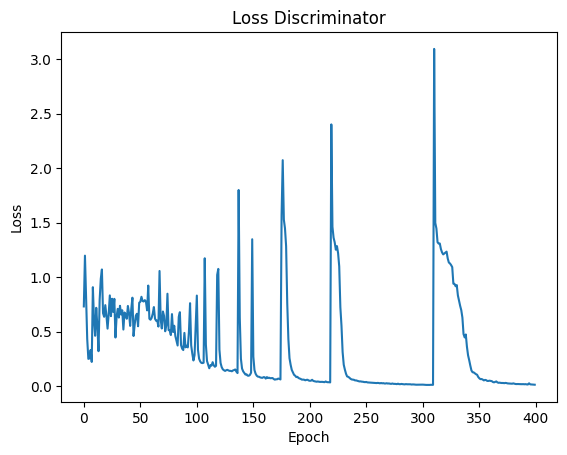

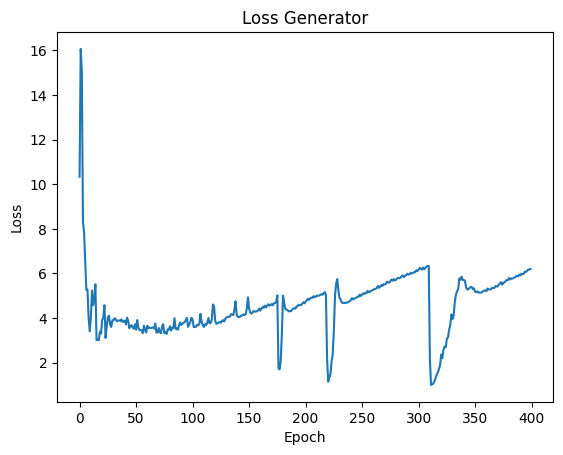

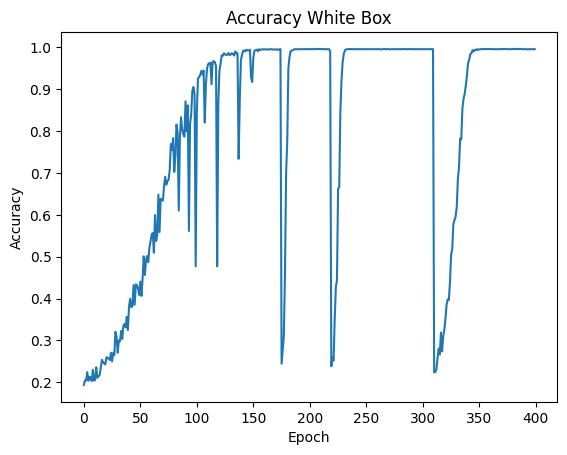

Loss Discriminator  Loss Generator  Accuracy Whitebox
0              0.730998       10.334126           0.193647
1              1.196929       16.068803           0.204032
2              0.810504       15.075559           0.204643
3              0.433100        8.290708           0.224191
4              0.249965        7.813014           0.203421
..                  ...             ...                ...
395            0.015850        6.074794           0.995724
396            0.014852        6.108324           0.995724
397            0.013666        6.173869           0.995724
398            0.013526        6.176142           0.995724
399            0.012625        6.198015           0.995724

[400 rows x 3 columns]

In [6]:
# Whitebox
opt = Options("./data", 2, 64, 64, 100, 64, 64, 400, 0.0002, 0.5, True, 1, '', '', './training/iteration5_flowers', 42, '')

# trainset = dset.CIFAR10(root=opt.dataroot, train=True, download=True, transform=data_transform)
# testset = dset.CIFAR10(root=opt.dataroot, train=False, download=True, transform=data_transform)

data_transform = transforms.Compose([
    transforms.Resize((opt.imageSize, opt.imageSize)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# trainset = dset.LFWPeople(root=opt.dataroot, split='train', download=True, transform=data_transform)
# testset = dset.LFWPeople(root=opt.dataroot, split='test', download=True, transform=data_transform)

trainset = dset.ImageFolder('./data/flowers/train/', transform=data_transform)
testset = dset.ImageFolder('./data/flowers/test/', transform=data_transform)
valset = dset.ImageFolder('./data/flowers/valid/', transform=data_transform)

testset = torch.utils.data.ConcatDataset([testset, valset])

lossesD, lossesG, accuracies = train_gan(opt, testset, trainset)
df_train_gan = pd.DataFrame({'Loss Discriminator' : lossesD, 'Loss Generator' : lossesG, 'Accuracy Whitebox' : accuracies})
df_train_gan.to_csv('results_train_gan_test_flowers.csv')
df_train_gan

In [9]:
# python attack.py --outf ./models --dataroot ./data --niter 10000 --cuda --netBBG ./models/netG_epoch_49.pth --netBBD ./models/netD_epoch_49.pth
opt = AttackOptions('./models', 2, 64, 64, 100, 64, 64, 50000, 0.0002, 0.5, True, 1, 
                          './training/iteration5_flowers/netG_epoch_399.pth', '', 
                          './training/iteration5_flowers/netD_epoch_399.pth', '', 
                          './training/iteration_black5_flowers', 42, 'CIFAR10')

data_transform = transforms.Compose([
  transforms.Resize((opt.imageSize, opt.imageSize)),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = dset.ImageFolder('./data/flowers/train/', transform=data_transform)
testset = dset.ImageFolder('./data/flowers/test/', transform=data_transform)
valset = dset.ImageFolder('./data/flowers/valid/', transform=data_transform)

testset = torch.utils.data.ConcatDataset([testset, valset])

lossesD, lossesG, accuracies = blackbox_attack(opt, testset, trainset)
df_black = pd.DataFrame({'Losses Discriminator' : lossesD, 'Losses Generator' : lossesG, 'Accurracy': accuracies})
df_black.to_csv('results_black_flowers.csv')

Random Seed:  42
==> Preparing data..
[0/50000] Loss_D: 1.9702 Loss_G: 6.8698 D(x): 0.7105 D(G(z)): 0.7434 / 0.0025
Accuracy: 0.19425778863775198
[1/50000] Loss_D: 0.9450 Loss_G: 5.1180 D(x): 0.6150 D(G(z)): 0.2734 / 0.0079
[2/50000] Loss_D: 0.7823 Loss_G: 6.5007 D(x): 0.8992 D(G(z)): 0.4287 / 0.0021
[3/50000] Loss_D: 0.5166 Loss_G: 7.1065 D(x): 0.8767 D(G(z)): 0.2545 / 0.0013
[4/50000] Loss_D: 0.5507 Loss_G: 6.4277 D(x): 0.7968 D(G(z)): 0.1884 / 0.0024
[5/50000] Loss_D: 0.6679 Loss_G: 7.5739 D(x): 0.8367 D(G(z)): 0.3131 / 0.0008
[6/50000] Loss_D: 0.5606 Loss_G: 8.1133 D(x): 0.8083 D(G(z)): 0.2241 / 0.0004
[7/50000] Loss_D: 0.3637 Loss_G: 7.7375 D(x): 0.8568 D(G(z)): 0.1452 / 0.0008
[8/50000] Loss_D: 0.6489 Loss_G: 9.9353 D(x): 0.8628 D(G(z)): 0.3180 / 0.0001
[9/50000] Loss_D: 0.4236 Loss_G: 7.9248 D(x): 0.8279 D(G(z)): 0.0788 / 0.0007
[10/50000] Loss_D: 0.5644 Loss_G: 10.5597 D(x): 0.8862 D(G(z)): 0.3067 / 0.0000
[11/50000] Loss_D: 0.3472 Loss_G: 8.1709 D(x): 0.8573 D(G(z)): 0.0483 / 